In [8]:
# Run some recommendation experiments using MovieLens 100K
%matplotlib inline
import pandas
import numpy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [13]:
data_dir = "ml-100k/"
data_shape = (943, 1682)

df = pandas.read_csv(data_dir + "ua.base", sep="\t", header=-1)
values = df.values
values[:, 0:2] -= 1
X_train = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=numpy.float, shape=data_shape)

df = pandas.read_csv(data_dir + "ua.test", sep="\t", header=-1)
values = df.values
values[:, 0:2] -= 1
X_test = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=numpy.float, shape=data_shape)

# Compute means of nonzero elements
X_row_mean = numpy.zeros(data_shape[0])
X_row_sum = numpy.zeros(data_shape[0])

train_rows, train_cols = X_train.nonzero()

# Iterate through nonzero elements to compute sums and counts of rows elements
for i in range(train_rows.shape[0]):
    X_row_mean[train_rows[i]] += X_train[train_rows[i], train_cols[i]]
    X_row_sum[train_rows[i]] += 1

# Note that (X_row_sum == 0) is required to prevent divide by zero
X_row_mean /= X_row_sum + (X_row_sum == 0)

# Subtract mean rating for each user
for i in range(train_rows.shape[0]):
    X_train[train_rows[i], train_cols[i]] -= X_row_mean[train_rows[i]]

test_rows, test_cols = X_test.nonzero()
for i in range(test_rows.shape[0]):
    X_test[test_rows[i], test_cols[i]] -= X_row_mean[test_rows[i]]

X_train = numpy.array(X_train.toarray())
X_test = numpy.array(X_test.toarray())

In [27]:
X_train[3][0]

0.0

(2, 0.7632419407797969, 0.80625312263304683)
(3, 0.75451351875789385, 0.80482838695320325)
(4, 0.74618150820108309, 0.80372971956371297)
(5, 0.73864003696706515, 0.80111452705032626)
(6, 0.7306512701022605, 0.79860615917606403)
(7, 0.72454306917527023, 0.79509425084225138)
(8, 0.71842252294320863, 0.79470049127499043)
(9, 0.71315872281744841, 0.79442238832108036)
(10, 0.70784348146897191, 0.79419230528125684)
(11, 0.70311131564933049, 0.79434443643201724)
(12, 0.69814815285774645, 0.79436054935803946)
(13, 0.69298358210731648, 0.79344400956336547)
(14, 0.68847439635900565, 0.79297086278635343)
(15, 0.6836396562235092, 0.79220818947932325)
(16, 0.6790602923886585, 0.79203613828028141)
(17, 0.67471280045813087, 0.79187118390049216)
(18, 0.67038478186961359, 0.79222839287659008)
(19, 0.66603693359688887, 0.79296222162066887)
(20, 0.66189142099289644, 0.79322683613296074)
(21, 0.6575440316880844, 0.79335341113795421)
(22, 0.65331611610017104, 0.79361820565628938)
(23, 0.6494722231973431, 0

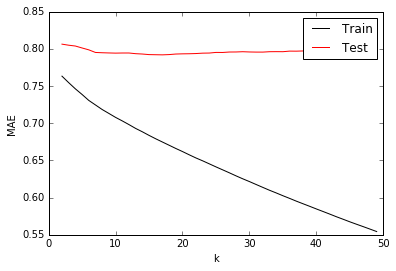

In [11]:
ks = numpy.arange(2, 50)
train_mae = numpy.zeros(ks.shape[0])
test_mae = numpy.zeros(ks.shape[0])
train_scores = X_train[(train_rows, train_cols)]
test_scores = X_test[(test_rows, test_cols)]

# Now take SVD of X_train
U, s, Vt = numpy.linalg.svd(X_train, full_matrices=False)

for j, k in enumerate(ks):
    X_pred = U[:, 0:k].dot(numpy.diag(s[0:k])).dot(Vt[0:k, :])

    pred_train_scores = X_pred[(train_rows, train_cols)]
    pred_test_scores = X_pred[(test_rows, test_cols)]

    train_mae[j] = mean_absolute_error(train_scores, pred_train_scores)
    test_mae[j] = mean_absolute_error(test_scores, pred_test_scores)

    print(k,  train_mae[j], test_mae[j])

plt.plot(ks, train_mae, 'k', label="Train")
plt.plot(ks, test_mae, 'r', label="Test")
plt.xlabel("k")
plt.ylabel("MAE")
plt.legend()
plt.show()

The strange learning curve above shows that we are overfitting the test data. The test curve shows no sign of learning.

The $a^{(k)}_{ij}$ element of the matrix $A_k$ is an approximation of the $a_{ij}$ element of the original matrix $A$. In particular, if you were to use the $U$, $\Sigma$, and $V$ matrices of expansion as they are (without the dimension reduction) you would have $a^{(k)}_{ij} = a^{ij}$. As a corollary, it's impossible to use the $A_k$ as a prediction matrix, because you _already_ have this information in matrix $A$. For example, if the $p^{th}$ user did not rate the $q^{th}$ product, $a_{pq}$ will be $0$. At the same time $a^{(k)}_{pq}$ will be $0$ too. Not a very insightful prediction, is it?